In [4]:
#This code ingests the provided dataset, throws out columns 5 and 6, and labels the columns.

loadData <- function(filepath = 'C:/Users/iakuznet/Desktop/the-fat-boys/data'){
	require(data.table)
	
	#The data is composed of 144 columns, with each 6 consecutive columns corresponding to 1 of 24 markers. Apparently column 5 and 6 of the data are unnecessary and should be thrown out.
	#List of fluorescent markers used
	markers <- c('Synap_1', 'Synap_2', 'VGlut1_1', 'VGlut1_2', 'VGlut2', 'VGlut3', 'PSD', 'Glur2', 'NDAR1', 'NR2B', 'GAD', 'VGAT', 'PV',
	'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'Tubuli', 'DAPI')
	
	#What columns 1-4 for each of the florescent markers coorespond to.
	labels <- c('Int_Bright','Local_Bright','Dist_COM','MOI')
	
	#Generate labels for each column
	col_labels <- c() 
	
	for (i in 1:length(markers)){
		for (j in 1:length(labels)){
			col_labels[(i - 1) * length(labels) + j] = paste(markers[i],"_",labels[j],sep = "")
		}
	}
	
	#Change to relevant location of file
	setwd(filepath)

	#Load in file using data.tables fread()
	data <- fread("synapsinR_7thA.tif.Pivots.txt.2011Features.txt")

	#Convert to dataframe
	data <- as.data.frame(data)

	#Remove columns 5 and 6 corresponding to each fluorescent marker
	good_ones <- c(1:dim(data)[2])
	dim(good_ones) <- c(6,dim(data)[2] / 6)
	good_ones <- good_ones[1:4,]
	dim(good_ones) <- c(4 * dim(good_ones)[2],1)
	data_cleaned <- data[,good_ones]
	
	#Label data
	colnames(data_cleaned) <- col_labels
	
	return(data_cleaned)
}

We load our dataset:

In [5]:
data <- loadData()

Loading required package: data.table
Warning message:
: package 'data.table' was built under R version 3.1.3

Read 1119299 rows and 144 (of 144) columns from 1.817 GB file in 00:06:42


In [6]:
#Subsamples 10000 rows from the original data set for easier analysis

subsampleRows <- function(data,samples = 10000,seed = 42){
	#Subsample some number of rows for further analysis. Set seed for reproducibility.
	set.seed(seed);rand_rows = sample(1:dim(data)[1],samples)
	subsample <- data[rand_rows,]
	return(subsample)
}

In [7]:
subsample <- subsampleRows(data)

In [8]:
#Scales each column of the input data frame by converting to Z scores and optionally log scaling the data

scaleData <- function(data,center = TRUE,scale = TRUE, log = TRUE){
	data_scaled <- scale(data, center = center,scale = scale)
    if(log){
        norm_0_1 <- function(x) {(x - min(x, na.rm=TRUE))/(max(x,na.rm=TRUE) - min(x, na.rm=TRUE))}
        data_scaled <- log(norm_0_1(data_scaled) + 1) / log(10)
    }
	return(data_scaled)
}

In [10]:
subsample <- scaleData(subsample, log = FALSE)
subsample_s <- scaleData(subsample, log = TRUE)

In [11]:
#For labeling

library(gplots)
library(colorRamps)

channel <- c('Synap_1','Synap_2','VGlut1_t1','VGlut1_t2','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI')
channel.type <- c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','other','other',
                  'other','other','other','other','none','none')
nchannel <- length(channel)
nfeat <- ncol(data) / nchannel
fchannel <- as.numeric(factor(channel.type,
    levels= c("synap","ex.pre","ex.post","in.pre","in.post","in.pre.small","other","none")
    ))
ford <- order(fchannel)
Syncol <- c("purple","#197300","#5ed155","#990000","#cc0000","#ff9933","mediumblue","gold")
ccol <- Syncol[fchannel]


fname <- as.vector(sapply(channel,function(x) paste0(x,paste0("F",0:5))))
names(subsample) <- fname
names(subsample_s) <- fname
fcol <- rep(ccol, each=6)
mycol <- colorpanel(100, "purple", "black", "green")
mycol2 <- matlab.like(nchannel)
    


Warning message:
: package 'gplots' was built under R version 3.1.3
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
: package 'colorRamps' was built under R version 3.1.3

In [12]:
#Use only f0

f0 <- seq(1,ncol(data),by=nfeat)
featF0s <- subset(subsample, select=f0)
flog <- subset(subsample_s, select=f0)

Compute correlation matrix

In [36]:
result <- cov(flog,flog)

,X1,X2,value
52,VGlut1_2,VGlut1_1,2.147713e-05


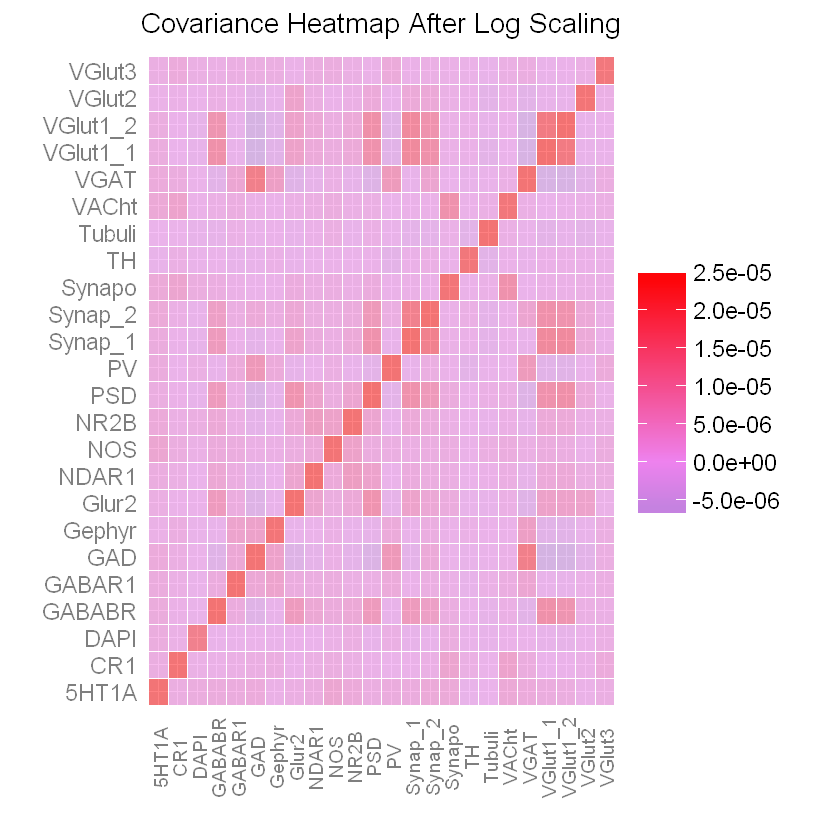

In [39]:
library(reshape)
library(naturalsort)
library(ggplot2)

temp <- melt(result)

levels(temp[,1]) <- naturalsort(levels(temp[,1]))
levels(temp[,2]) <- naturalsort(levels(temp[,2]))
temp = temp[naturalorder(temp[,1]),]

for (i in 4 * (0:(dim(result)[2] - 1)) + 1){
	loop_temp <- temp[i:(i + 3),]
	temp[i:(i + 3),] = loop_temp[naturalorder(temp[i:(i + 3),2]),]
}

temp$X1 <- gsub('_Int_Bright','',temp$X1)
temp$X2 <- gsub('_Int_Bright','',temp$X2)

base_size <- 20
p1 <- ggplot(temp, aes(X2, X1, fill = value)) + geom_tile(alpha = 0.5, colour = "white") + 
scale_fill_gradient2(low = "steelblue", high = "red", mid = "violet", name = "") + 
theme_grey(base_size = base_size) + labs(x = "", y = "") + scale_x_discrete(expand = c(0, 0)) + scale_y_discrete(expand = c(0, 0)) + 
ggtitle("Covariance Heatmap After Log Scaling") + 
theme(axis.ticks = element_blank(), plot.title = element_text(vjust=2), axis.text.x = element_text(angle=90, vjust = 0.6), 
      text = element_text(size=14),axis.text.y = element_text(size = 14), legend.text=element_text(size=14), 
      legend.title = element_text(size = 14)) + guides(fill = guide_colorbar(barwidth = 2, barheight = 10, title.position = "top", title.vjust = 10))

temp[507,]
p1

Saving 7 x 7 in image


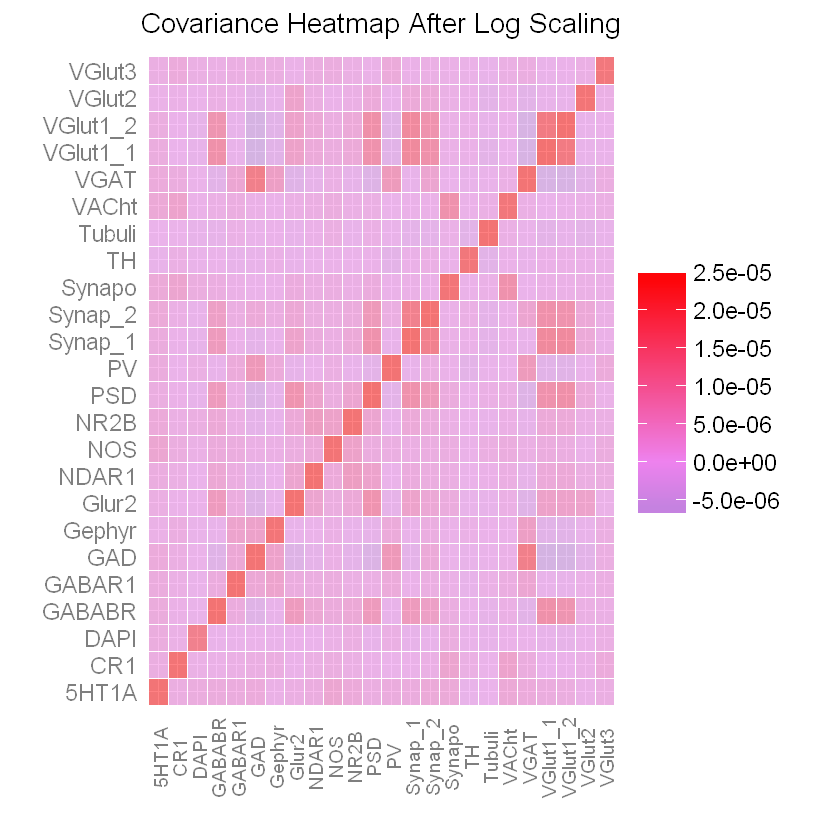

In [40]:
p1
ggsave('C:/users/iakuznet/Desktop/Covariance.png')

Last week we tested colocalization by characterizing the 1-NN distance from GABABR to other markers. However, we did this in 2D rather than 3D. We redo last week's work with better sorting for easier visualization:

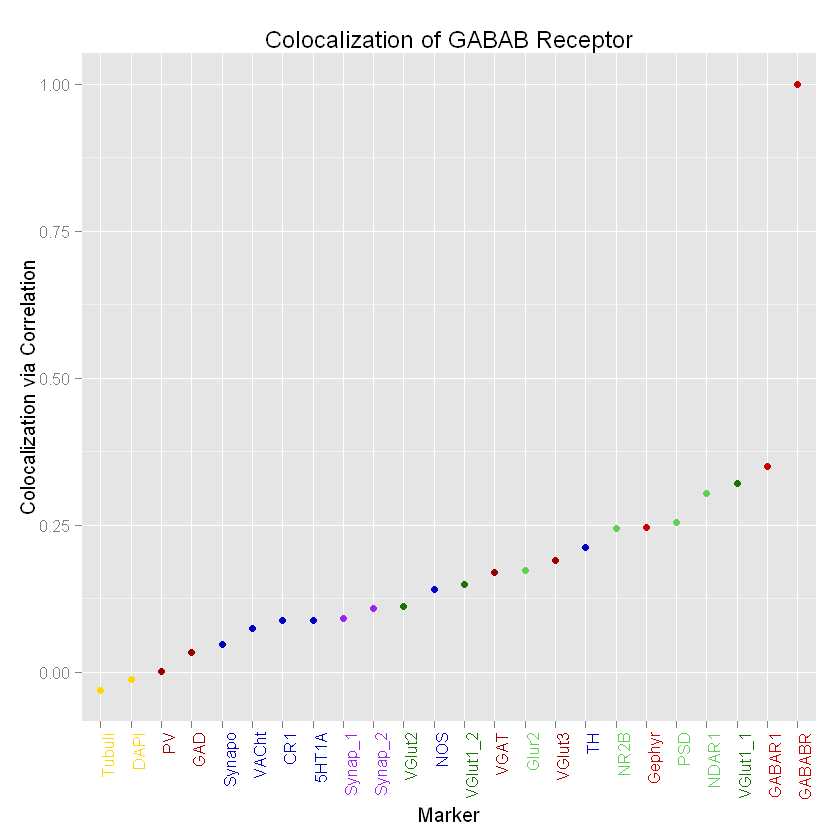

In [77]:
library(ggplot2)

names <- gsub('_Int_Bright','',colnames(flog))
corr <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/corr_GABABR.csv",data.table = FALSE)
colnames(corr) <- names
corr <- t(corr)
corr <- cbind(corr,as.data.frame(names))
colnames(corr) <- c('corr','names')
sort_res <- sort(corr$corr,index.return = TRUE)
corr$names <- factor(corr$names,corr$names[sort_res$ix])

color_use <- ccol[sort_res$ix]


p1 <- ggplot(corr,aes(factor(names),corr, color = names)) + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1, color=color_use))
p1 <- p1 + scale_color_manual(values=color_use) + theme(legend.position = "none")
p1 <- p1 + xlab('Marker') + ylab('Colocalization via Correlation') + ggtitle('Colocalization of GABAB Receptor')
p1



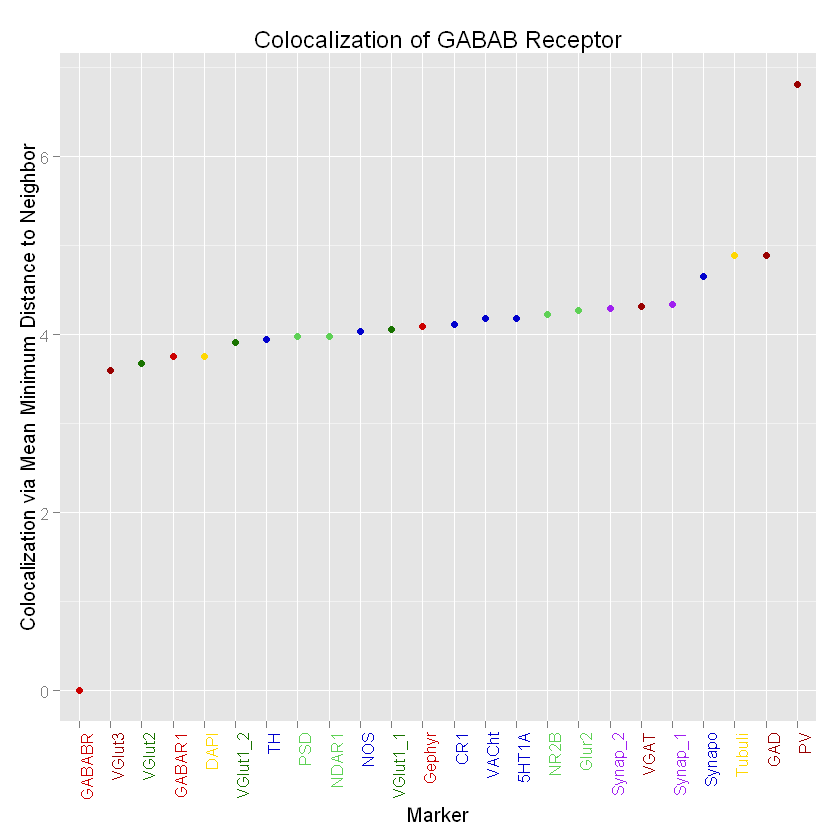

In [81]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_GABABR.csv",data.table = FALSE)
dist_res <- dist_res[3,-1]
colnames(dist_res) <- names
dist_res <- t(dist_res)
dist_res <- cbind(dist_res,as.data.frame(names))
colnames(dist_res) <- c('dist','names')
sort_res <- sort(dist_res$dist,index.return = TRUE)
dist_res$names <- factor(dist_res$names,dist_res$names[sort_res$ix])

color_use <- ccol[sort_res$ix]

p2 <- ggplot(dist_res,aes(names,dist, color = names)) + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1, color=color_use))
p2 <- p2 + scale_color_manual(values=color_use) + theme(legend.position = "none")
p2 <- p2 + xlab('Marker') + ylab('Colocalization via Mean Minimum Distance to Neighbor') + ggtitle('Colocalization of GABAB Receptor')
p2



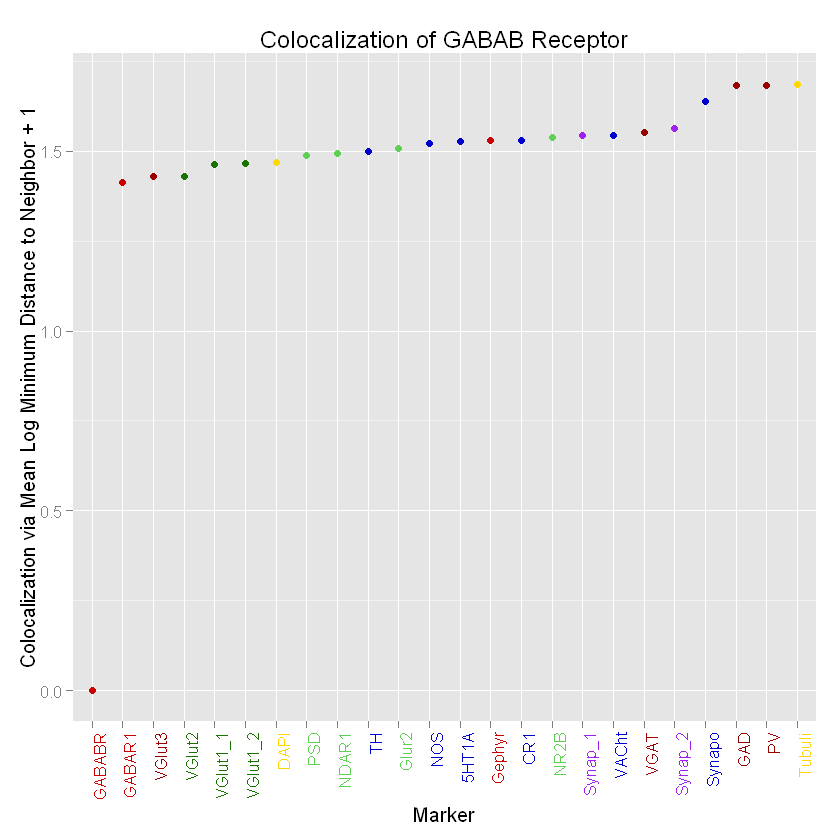

In [84]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_GABABR.csv",data.table = FALSE)
dist_res <- dist_res[4,-1]
colnames(dist_res) <- names
dist_res <- t(dist_res)
dist_res <- cbind(dist_res,as.data.frame(names))
colnames(dist_res) <- c('dist','names')
sort_res <- sort(dist_res$dist,index.return = TRUE)
dist_res$names <- factor(dist_res$names,dist_res$names[sort_res$ix])

color_use <- ccol[sort_res$ix]

p3 <- ggplot(dist_res,aes(names,dist, color = names)) + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1, color=color_use))
p3 <- p3 + scale_color_manual(values=color_use) + theme(legend.position = "none")
p3 <- p3 + xlab('Marker') + ylab('Colocalization via Mean Log Minimum Distance to Neighbor + 1') + ggtitle('Colocalization of GABAB Receptor')
p3



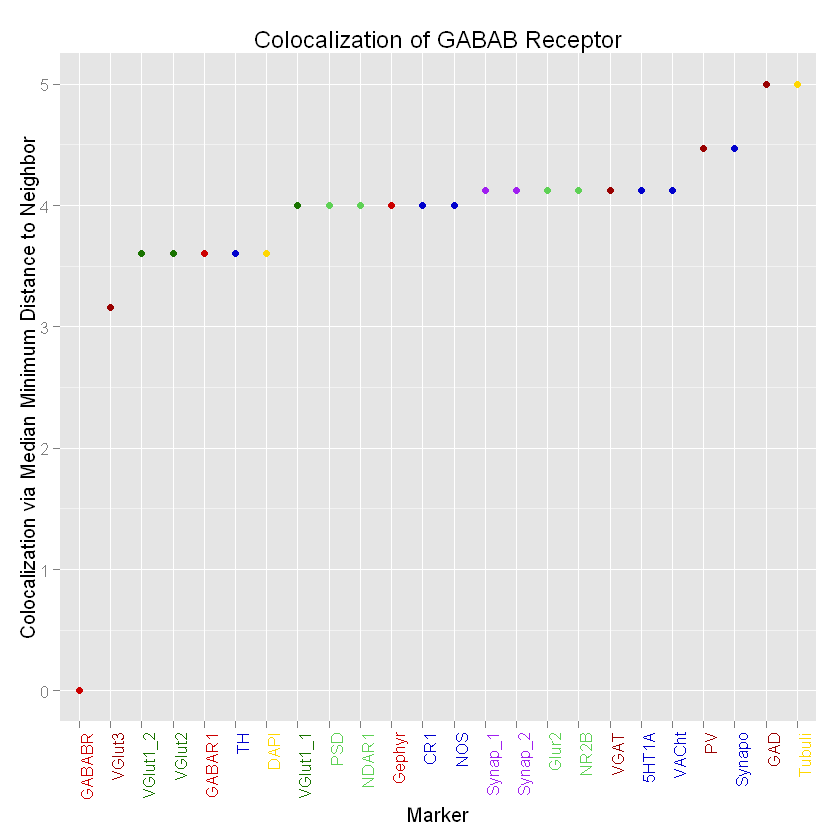

In [85]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_GABABR.csv",data.table = FALSE)
dist_res <- dist_res[5,-1]
colnames(dist_res) <- names
dist_res <- t(dist_res)
dist_res <- cbind(dist_res,as.data.frame(names))
colnames(dist_res) <- c('dist','names')
sort_res <- sort(dist_res$dist,index.return = TRUE)
dist_res$names <- factor(dist_res$names,dist_res$names[sort_res$ix])

color_use <- ccol[sort_res$ix]

p3 <- ggplot(dist_res,aes(names,dist, color = names)) + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1, color=color_use))
p3 <- p3 + scale_color_manual(values=color_use) + theme(legend.position = "none")
p3 <- p3 + xlab('Marker') + ylab('Colocalization via Median Minimum Distance to Neighbor') + ggtitle('Colocalization of GABAB Receptor')
p3



Now we redo the above in 3D and take into account the actual voxel dimensions. Note that we are still ignoring border effects on the assumption that they are negligable:

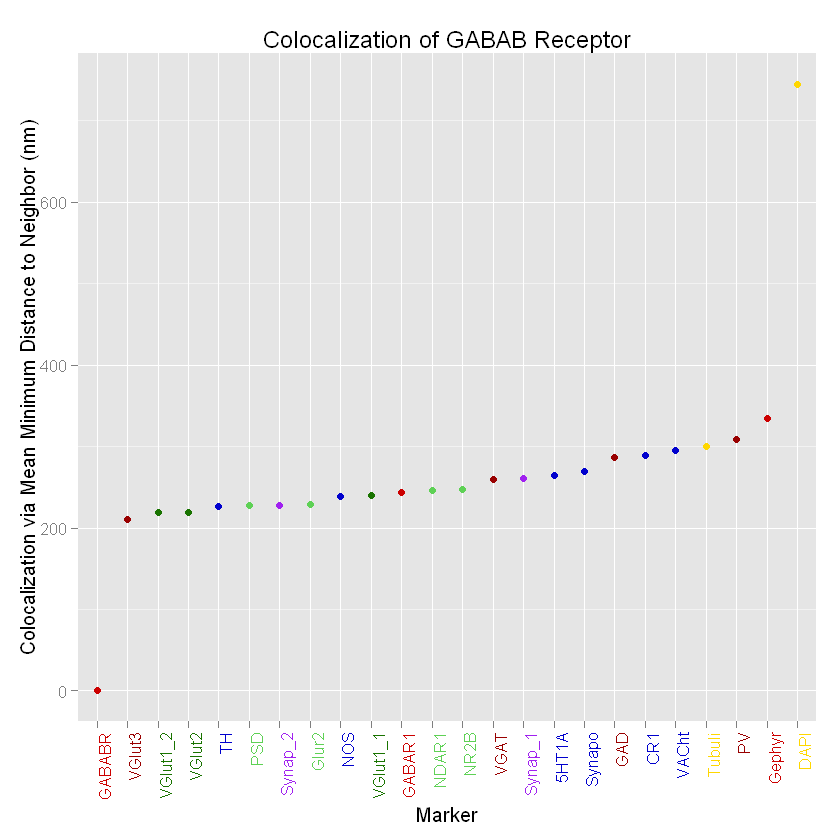

In [90]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_GABABR.csv",data.table = FALSE)
dist_res <- dist_res[8,-1]
colnames(dist_res) <- names
dist_res <- t(dist_res)
dist_res <- cbind(dist_res,as.data.frame(names))
colnames(dist_res) <- c('dist','names')
sort_res <- sort(dist_res$dist,index.return = TRUE)
dist_res$names <- factor(dist_res$names,dist_res$names[sort_res$ix])

color_use <- ccol[sort_res$ix]

p4 <- ggplot(dist_res,aes(names,dist, color = names)) + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1, color=color_use))
p4 <- p4 + scale_color_manual(values=color_use) + theme(legend.position = "none")
p4 <- p4 + xlab('Marker') + ylab('Colocalization via Mean Minimum Distance to Neighbor (nm)') + ggtitle('Colocalization of GABAB Receptor')
p4



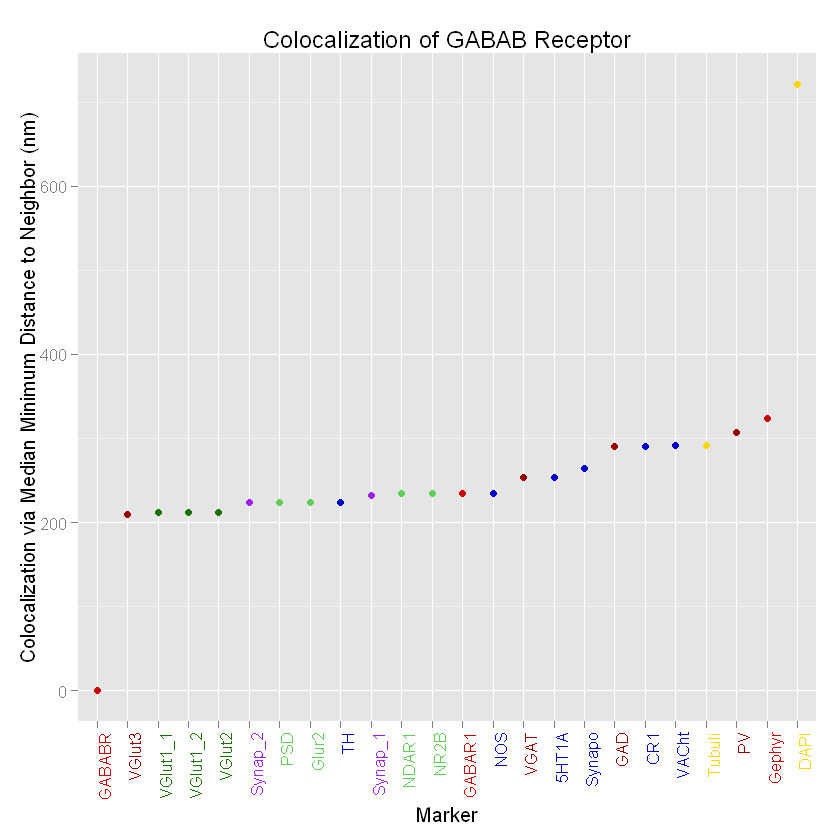

In [91]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_GABABR.csv",data.table = FALSE)
dist_res <- dist_res[9,-1]
colnames(dist_res) <- names
dist_res <- t(dist_res)
dist_res <- cbind(dist_res,as.data.frame(names))
colnames(dist_res) <- c('dist','names')
sort_res <- sort(dist_res$dist,index.return = TRUE)
dist_res$names <- factor(dist_res$names,dist_res$names[sort_res$ix])

color_use <- ccol[sort_res$ix]

p5 <- ggplot(dist_res,aes(names,dist, color = names)) + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1, color=color_use))
p5 <- p5 + scale_color_manual(values=color_use) + theme(legend.position = "none")
p5 <- p5 + xlab('Marker') + ylab('Colocalization via Median Minimum Distance to Neighbor (nm)') + ggtitle('Colocalization of GABAB Receptor')
p5



Now we compute all the colocalizations:

 [1] "purple"     "purple"     "#197300"    "#197300"    "#197300"   
 [6] "#990000"    "#5ed155"    "#5ed155"    "#5ed155"    "#5ed155"   
[11] "#990000"    "#990000"    "#990000"    "#cc0000"    "#cc0000"   
[16] "#cc0000"    "mediumblue" "mediumblue" "mediumblue" "mediumblue"
[21] "mediumblue" "mediumblue" "gold"       "gold"      


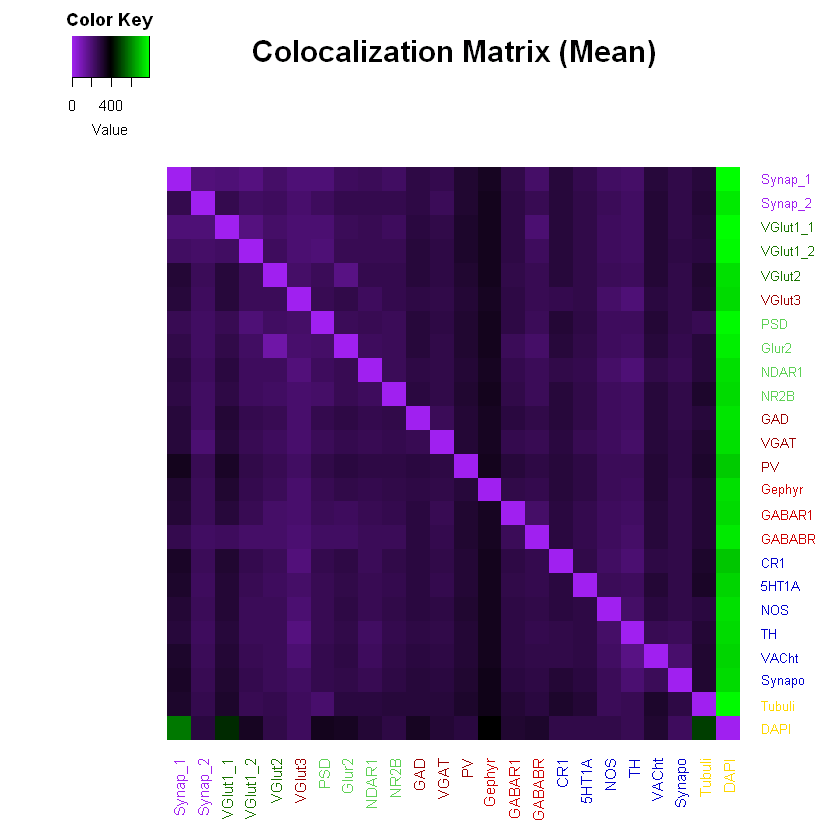

In [123]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_all_mean.csv",data.table = FALSE)
dist_res <- dist_res[,-1]
colnames(dist_res) <- names
rownames(dist_res) <- names

heatmap.2(as.matrix(dist_res), Rowv=FALSE, Colv = FALSE, trace="none",dendrogram = "none", col=mycol,colCol=ccol,colRow = ccol, 
          density.info = "none", cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90,
          main ="Colocalization Matrix (Mean)")



 [1] "purple"     "purple"     "#197300"    "#197300"    "#197300"   
 [6] "#990000"    "#5ed155"    "#5ed155"    "#5ed155"    "#5ed155"   
[11] "#990000"    "#990000"    "#990000"    "#cc0000"    "#cc0000"   
[16] "#cc0000"    "mediumblue" "mediumblue" "mediumblue" "mediumblue"
[21] "mediumblue" "mediumblue" "gold"      


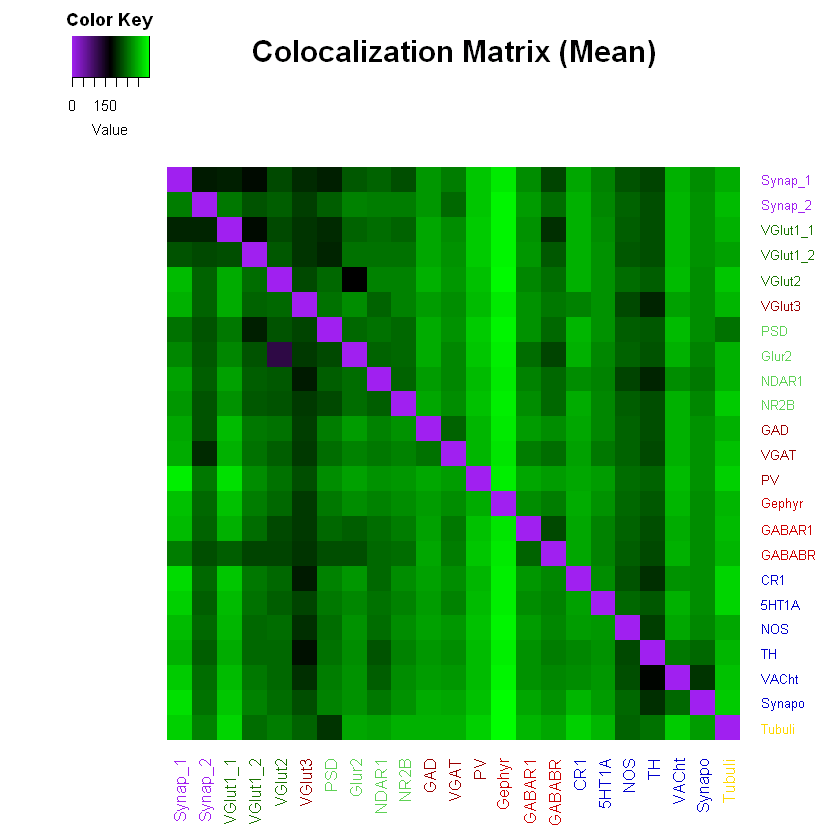

In [125]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_all_mean.csv",data.table = FALSE)
dist_res <- dist_res[-24,c(-1,-25)]
colnames(dist_res) <- names[-24]
rownames(dist_res) <- names[-24]

heatmap.2(as.matrix(dist_res), Rowv=FALSE, Colv = FALSE, trace="none",dendrogram = "none", col=mycol[-24],colCol=ccol[-24],colRow = ccol[-24], 
          density.info = "none", cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90,
          main ="Colocalization Matrix (Mean)")



 [1] "purple"     "purple"     "#197300"    "#197300"    "#197300"   
 [6] "#990000"    "#5ed155"    "#5ed155"    "#5ed155"    "#5ed155"   
[11] "#990000"    "#990000"    "#990000"    "#cc0000"    "#cc0000"   
[16] "#cc0000"    "mediumblue" "mediumblue" "mediumblue" "mediumblue"
[21] "mediumblue" "mediumblue" "gold"       "gold"      


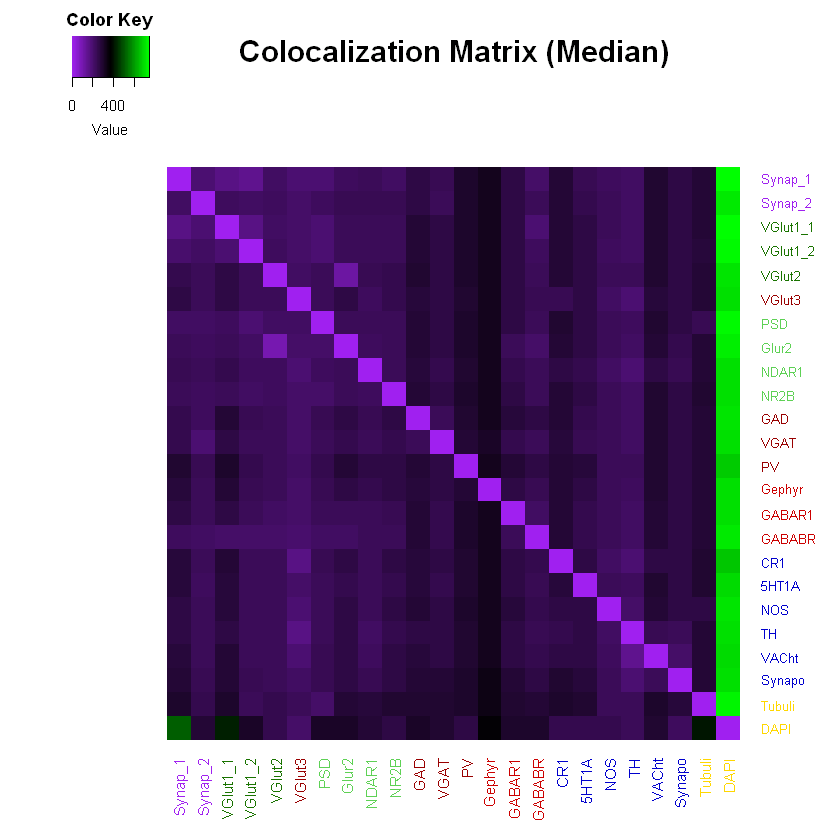

In [126]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_all_median.csv",data.table = FALSE)
dist_res <- dist_res[,-1]
colnames(dist_res) <- names
rownames(dist_res) <- names

heatmap.2(as.matrix(dist_res), Rowv=FALSE, Colv = FALSE, trace="none",dendrogram = "none", col=mycol,colCol=ccol,colRow = ccol, 
          density.info = "none", cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90,
          main ="Colocalization Matrix (Median)")

 [1] "purple"     "purple"     "#197300"    "#197300"    "#197300"   
 [6] "#990000"    "#5ed155"    "#5ed155"    "#5ed155"    "#5ed155"   
[11] "#990000"    "#990000"    "#990000"    "#cc0000"    "#cc0000"   
[16] "#cc0000"    "mediumblue" "mediumblue" "mediumblue" "mediumblue"
[21] "mediumblue" "mediumblue" "gold"      


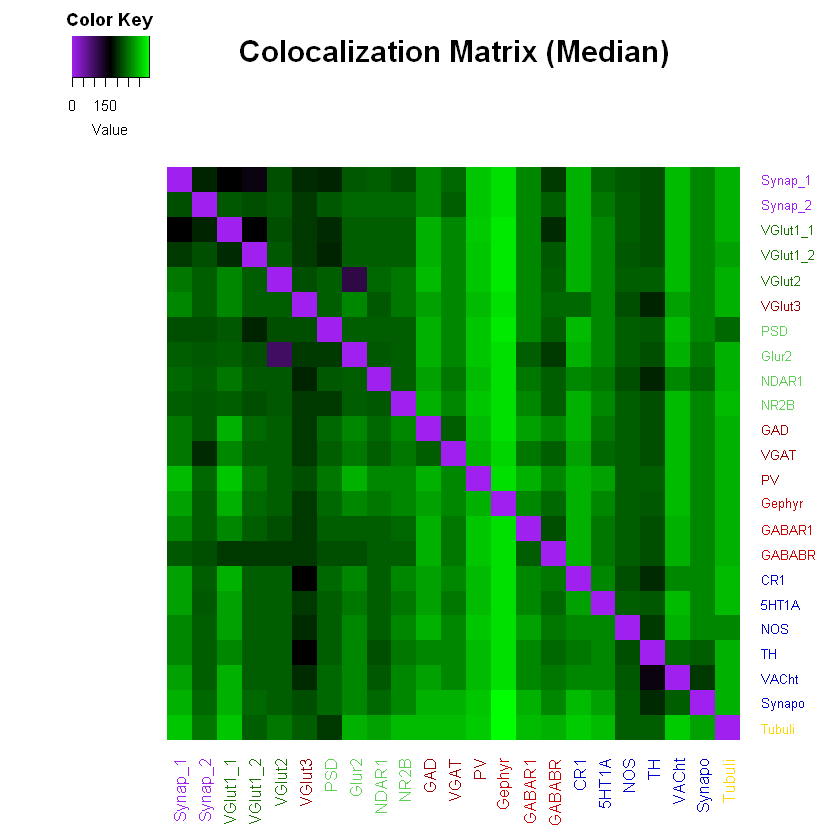

In [128]:
dist_res <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/data/analysis_all_median.csv",data.table = FALSE)
dist_res <- dist_res[-24,c(-1,-25)]
colnames(dist_res) <- names[-24]
rownames(dist_res) <- names[-24]

heatmap.2(as.matrix(dist_res), Rowv=FALSE, Colv = FALSE, trace="none",dendrogram = "none", col=mycol[-24],colCol=ccol[-24],colRow = ccol[-24], 
          density.info = "none", cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90,
          main ="Colocalization Matrix (Median)")

Warning message:
In loop_apply(n, do.ply): Removed 7667 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7661 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 9138 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7369 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7765 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 8516 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7641 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7790 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7455 rows containing non-finite values (stat_density).Warning message:
In loop_apply(n, do.ply): Removed 7305

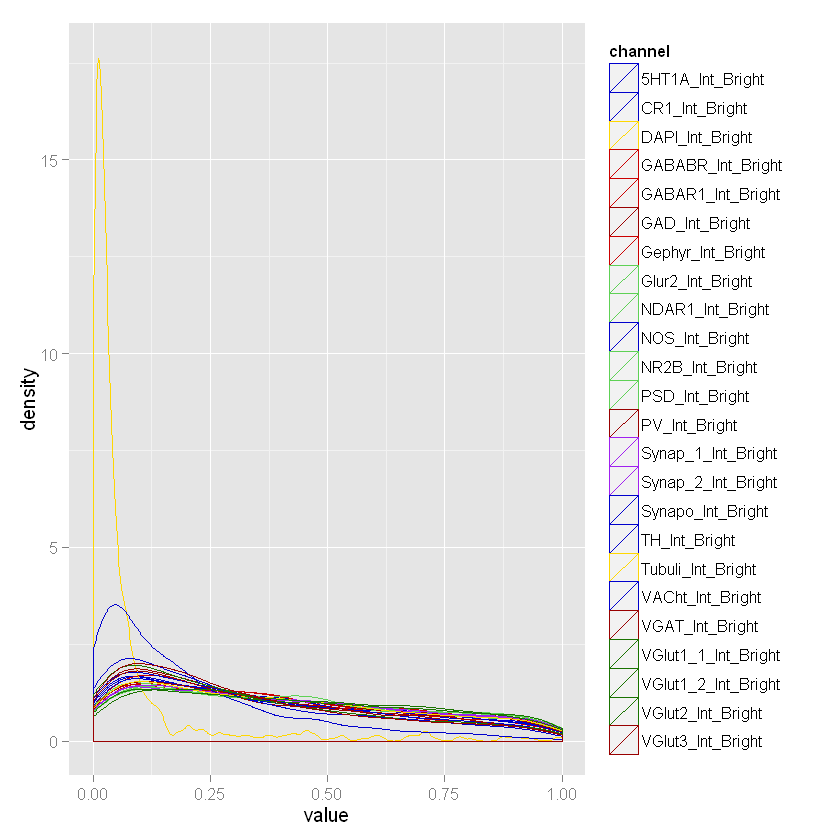

In [67]:
#Visualize the marginals without log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s)

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol[sort(colnames(featF0s), index.return = TRUE)$ix]) +
    scale_x_continuous(limits=c(0,1))+
    geom_density(aes(group=channel, colour=channel))

In [ ]:
#Visualize the marginals without log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog)

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol[sort(colnames(featF0s), index.return = TRUE)$ix]) +
    scale_x_continuous(limits=c(0.075,0.12)) +
    geom_density(aes(group=channel, colour=channel))